# Quantum Circuit Optimization with Reinforcement Learning on qBraid


In [6]:
import string
from typing import List, Optional


import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import numpy as np
from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import standard_gates, iSwapGate
from qiskit.converters import circuit_to_dag
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler.passes import (
    CommutativeCancellation,
    CXCancellation,
    Optimize1qGatesDecomposition,
    Collect2qBlocks,
)
from qiskit.quantum_info import Statevector
from qiskit.transpiler import PassManager
from qiskit.visualization import dag_drawer
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter


torch.manual_seed(1)

## What is quantum circuit optimization?

Quantum Circuit Optimization (QCO) is the process where a series of
transformation are applied to a quantum circuit to reduce the depth and number
of gates on a circuit as well as tailoring the circuit for a specific hardware.
In the NISQ era where increasing circuit depth and gates can compound error and
there are limits to the availability of gates and qubits, it is crucial to
optimize your circuit to increase accuracy!

You may have already optimized a quantum circuit on qiskit if you have ran the
`.transpile()` function. Let's check out the example below to see the function
in action. You may not get a reduction in depth or gates,which is okay! This is
because the circuit is already optimized with the given optimization level.
**Example:**


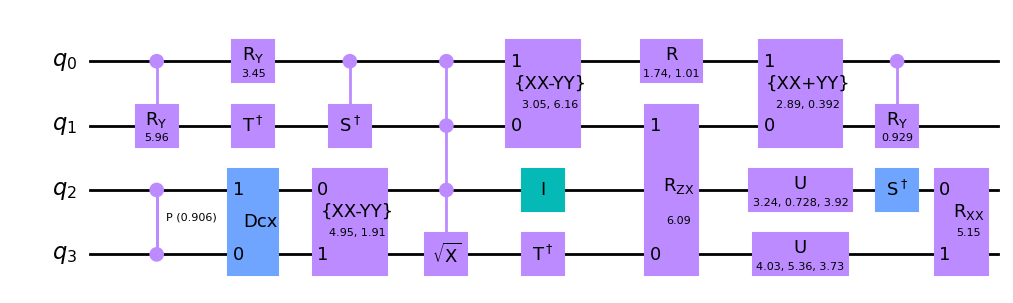

In [29]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile


def sample_circuit() -> QuantumCircuit:
    """Sample a random circuit"""
    return random_circuit(num_qubits=4, depth=8, measure=False, seed=1)


# Draw the circuit
circuit = sample_circuit()
circuit.draw("mpl")

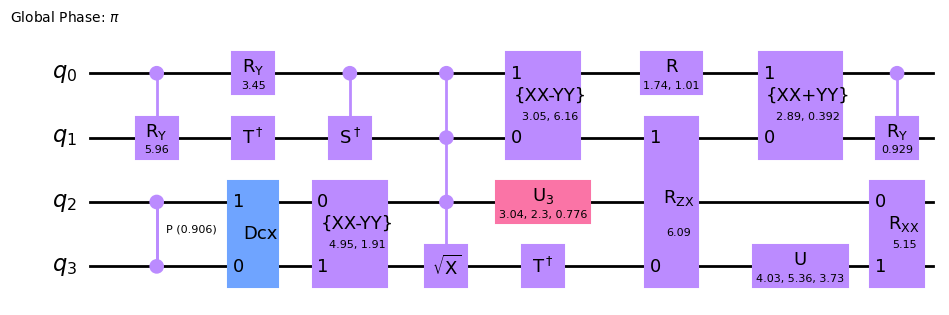

In [30]:
# Transpile the circuit
transpiled_circuit = transpile(circuit, optimization_level=2)
transpiled_circuit.draw("mpl")

In [31]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{transpiled_circuit.depth()}")
print(f"New Gates:{sum(dict(transpiled_circuit.count_ops()).values())}")

Original Depth:8
Original Gates:19
New Depth:8
New Gates:17


What's happening underneath the `.transpile()` function, among other things such
as layouting virtual qubits onto physical ones etc, is that a series of
optimizations, called passes are being performed on the circuit. For the above
example, the following passes are being applied if ran on Qiskit's 16 qubit machine Guadalupe:


In [32]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import FakeGuadalupeV2

# Change the backend to see how the number of passes changes
backend = FakeGuadalupeV2()

# Adjust the optimization level to see how the number of passes changes
pass_manager = generate_preset_pass_manager(3, backend)

print(f"The pass manager for {FakeGuadalupeV2.backend_name} has the following passes: \n")

# Print out the passes in the pass manager
for i, pass_ in enumerate(pass_manager.passes()):
    if type(pass_["passes"]) is list:
        print(f"{i}: {pass_['passes'][0].name()}")
    else:
        print(f"{i}: {pass_['passes']}")

The pass manager for fake_guadalupe has the following passes: 

0: ContainsInstruction
1: Error
2: UnitarySynthesis
3: HighLevelSynthesis
4: Unroll3qOrMore
5: RemoveResetInZeroState
6: OptimizeSwapBeforeMeasure
7: RemoveDiagonalGatesBeforeMeasure
8: SetLayout
9: VF2Layout
10: BarrierBeforeFinalMeasurements
11: FullAncillaAllocation
12: CheckMap
13: BarrierBeforeFinalMeasurements
14: VF2PostLayout
15: ApplyLayout
16: UnitarySynthesis
17: RemoveResetInZeroState
18: Depth
19: Collect2qBlocks
20: ContainsInstruction
21: TimeUnitConversion


/Users/rickyyoung/opt/anaconda3/envs/rlco/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/rickyyoung/opt/anaconda3/envs/rlco/lib/python3.9/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


For 90% of the time, this is all you need to do to optimize your circuit.
However, if you want to go a bit deeper, you can customize the pass manager to
apply specific optimizations to your circuit.

Today we'll cover how to customize the pass manager for optimizing quantum gates
on virtual qubits. You'll use qiskit to go a bit deeper than using the
`.transpile()` function and it's default optimization strategies which is a
great starting point for improving the performance of an algorithim that you may want to
run on a quantum computer. After learning about some of the most notable
transformations we will apply the optimizations discussed in an RL model to
optimize a circuit. Note, there are many many strategies and nuances in quantum
circuit optimization, which includes qubit mapping, gate synthesis, and more
along. Not only are there many strategies, but many quantum computing frameworks have their own strategies
tailored to their hardware as well. This notebook will focus on some of the optimization
strategies that are available in qiskit and how to use them. The notebook is intended to
be a starting point for you to explore the field of quantum circuit
optimization, a filed rich in exciting papers coming out.


## Why is it so hard?

Quantum circuit optimization is incredibly complex and time consuming since
applying optimization passes is a heuristic process of reducing the number of
gates and depth of a circuit. When quantum hardware is involved, deciding on
what optimization strategy is best is a difficult process where the globally
optimal quantum circuit is incredible hard to determine with typical decision
making strategies. There are notable strategies such as annealing, genetic
algorithms and tensornetworks which offer computationally intensive solutions

### Arriving at sub-optimal solutions

Even with small circuits, it is easy to arrivate at a sub-optimal solution.
Here's a simple example of a circuit that is not optimized and the optimized
version of it. The optimized version is 2 gates shorter and 1 gate less than the
original circuit.

#### How would you optimize this 1 qubit circuit?

$$HZXHXZXY$$

A quick inspection of the gates that are applied may lead you to a solution
where you get rid of the $ZXY$ with the identity $XYZ = I$ at the end of the
operation sequence:

$$HZXHX$$

However this is not the optimal solution and there are ways to optimize this
circuit further!

**Optimized version:** Beginning with the same un-optimized circuit:
$$HZXHXZXY$$

We can insert the circuit identity $YHYH = I$ after the first hadamard to get:

$$HZXHXZXY = H\bold{HYHY}ZXHXZXY$$

$$ HHYHYZXHXZXY $$

We can then apply the same identity used before $YZX = I$:

$$HHYHHX$$

We can then apply the identity $HH = I$ to get the globally optimal solution:

$$YX$$


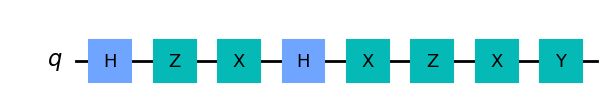

In [33]:
# Verify the optimization on qiskit

example_circuit = QuantumCircuit(1)
example_circuit.h(0)
example_circuit.z(0)
example_circuit.x(0)
example_circuit.h(0)
example_circuit.x(0)
example_circuit.z(0)
example_circuit.x(0)
example_circuit.y(0)

example_circuit.draw("mpl")

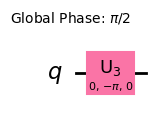

In [34]:
# Transpile the circuit
transpiled_circuit = transpile(example_circuit, optimization_level=1)
transpiled_circuit.draw("mpl")

### Large circuits have a large search space

As dmeonstrated above, even with a small circuit, it can be tricky to arrive at the global optimal solution. As the circuit size increases, you can imagine how the search space dramatically increases and the option to, for example move commuting gates around to reduce depth, becomes more complex. 

A simple example of the dramatic increase in optimization can be demonstrated by applying the `.transpile()` function on a very large circuit. The circuit below is a 5 qubit circuit with 500 gates, a relatively manageable number of gates for up and coming NISQ devices. Timing the `.transpile()` function on this random circuit takes 1.5 seconds on my machine at an optimization level 3. What about yours? Do you see an exponential in your graph?

In [41]:
import time

# Define the circuit
circuit = random_circuit(num_qubits=4, depth=500, measure=False, seed=1)
# Define the optimization levels to test
optimization_levels = [0, 1, 2, 3]


def optimize_circuits(circuit: QuantumCircuit, optimization_levels: List[int]) -> List[float]:
    """Optimize the circuit at each optimization level"""
    # Create an empty list to store the times
    times = []
    for optimization_level in optimization_levels:
        # Start the timer
        start = time.time()
        transpiled_circuit = transpile(circuit, optimization_level=optimization_level)
        # End the timer
        end = time.time()
        # Append the time to the list
        times.append(end - start)
        print(
            f"Circuit Depth {circuit.depth()}, Optimization Level {optimization_level} took {end - start} seconds"
        )
    return times

Optimization Level 0 took 0.013950109481811523 seconds
Optimization Level 1 took 0.02329087257385254 seconds
Optimization Level 2 took 0.15932703018188477 seconds
Optimization Level 3 took 0.48453187942504883 seconds
Optimization Level 0 took 0.012370109558105469 seconds
Optimization Level 1 took 0.031331777572631836 seconds
Optimization Level 2 took 0.21960783004760742 seconds
Optimization Level 3 took 0.6531178951263428 seconds
Optimization Level 0 took 0.01579594612121582 seconds
Optimization Level 1 took 0.04006791114807129 seconds
Optimization Level 2 took 0.28941798210144043 seconds
Optimization Level 3 took 0.9205951690673828 seconds
Optimization Level 0 took 0.7704730033874512 seconds
Optimization Level 1 took 0.07765793800354004 seconds
Optimization Level 2 took 0.3738689422607422 seconds
Optimization Level 3 took 1.106515884399414 seconds


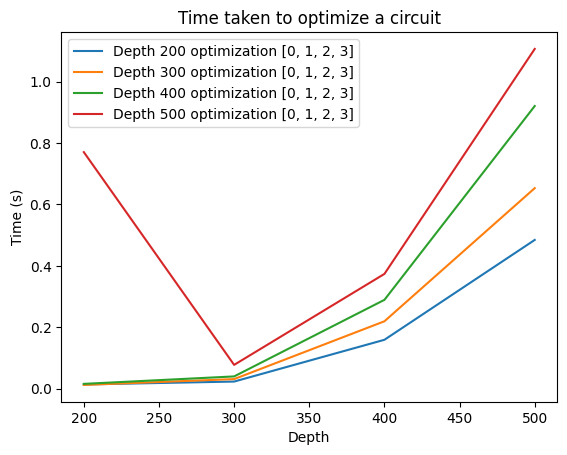

In [49]:
# Plot the time taken for each optimization level and the depth of the circuit
import matplotlib.pyplot as plt

depths = [200, 300, 400, 500]
for depth in depths:
    # Define the circuit
    circuit = random_circuit(num_qubits=4, depth=depth, measure=False, seed=1)
    # Define the optimization levels to test
    optimization_levels = [0, 1, 2, 3]
    # Optimize the circuit
    times = optimize_circuits(circuit, optimization_levels)
    # Plot the results
    plt.plot(depths, times, label=f"Depth {depth} optimization {optimization_levels}")
    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("Time (s)")
    plt.title("Time taken to optimize a circuit")

### Other notable challenges

There are many other challenges in quantum circuit optimization such as:

#### Parameterized circuits
While not covered here, parameterized circuits are another layer of complexity that can be added to the optimization process. Some work that tackles this include Adapt-VQE which allows for quasi optimial solutions with shallow circuits. 



#### Hardware constraints
Hardware constraints such as connectivity and gate availability can make the optimization process more complex. For example, if you have a circuit that is optimized for a 5 qubit device, it may not be optimized for a 16 qubit device. This is because the connectivity of the 5 qubit device may be different than the 16 qubit device. This is where qubit mapping comes in, which is not covered in this notebook.


## A brief overview of the optimization strategies available in qiskit


### What are some existing techniques??

No all of the passes are used for reducing the depth and number of gates on a circuit. Some of the passes are used for layouting virtual qubits onto physical qubits, and other passes are used for optimizing the circuit for a specific hardware or for checking the circuit for errors.

In [50]:
from qiskit.transpiler import passes

[pass_ for pass_ in dir(passes) if pass_[0].isupper()]

['ALAPSchedule',
 'ALAPScheduleAnalysis',
 'ASAPSchedule',
 'ASAPScheduleAnalysis',
 'AlignMeasures',
 'ApplyLayout',
 'BIPMapping',
 'BarrierBeforeFinalMeasurements',
 'BasicSwap',
 'BasisTranslator',
 'CSPLayout',
 'CXCancellation',
 'CXDirection',
 'CheckCXDirection',
 'CheckGateDirection',
 'CheckMap',
 'Collect1qRuns',
 'Collect2qBlocks',
 'CollectCliffords',
 'CollectLinearFunctions',
 'CollectMultiQBlocks',
 'CommutationAnalysis',
 'CommutativeCancellation',
 'CommutativeInverseCancellation',
 'Commuting2qGateRouter',
 'ConsolidateBlocks',
 'ConstrainedReschedule',
 'ContainsInstruction',
 'ConvertConditionsToIfOps',
 'CountOps',
 'CountOpsLongestPath',
 'CrosstalkAdaptiveSchedule',
 'DAGFixedPoint',
 'DAGLongestPath',
 'Decompose',
 'DenseLayout',
 'Depth',
 'DynamicalDecoupling',
 'EchoRZXWeylDecomposition',
 'EnlargeWithAncilla',
 'Error',
 'FixedPoint',
 'FullAncillaAllocation',
 'GateDirection',
 'GatesInBasis',
 'HighLevelSynthesis',
 'HoareOptimizer',
 'InstructionDuratio

#### Optimize 1 Qubit Gates Decomposition

1qgatedecomposition optimizes circuits by combining 1 qubit gates into a single
Unitary gate. The operations performed on the qubit by each of the gates are
swapped with a single U3 gate where the qubit is rotated according to the
product of the matrix. Here's a quick example done by using the following
equations:

One example of this is the following: where
$S^\dagger X S = \begin{bmatrix}
1 & 0 \\
0 & -i
\end{bmatrix}
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
1 & 0 \\
0 & i
\end{bmatrix} =  U3(\pi,0,0)$


Before optimization:


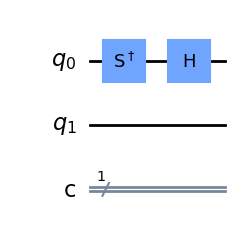

In [51]:
# Here's an example of how to use the pass manager
def optimize_1q_gates_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(QuantumRegister(2, "q"), ClassicalRegister(1, "c"))
    circuit.sdg(0)
    circuit.h(0)
    return circuit


circuit = optimize_1q_gates_circuit()

print("Before optimization:")
circuit.draw("mpl")

After optimization:


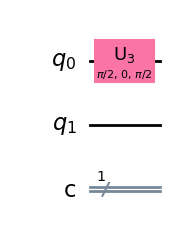

In [52]:
# 1q gate optimization
optimize_1q = PassManager([Optimize1qGatesDecomposition()])

# Get the result circuit
result = optimize_1q.run(circuit)

print("After optimization:")
result.draw("mpl")

In [53]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{result.depth()}")
print(f"New Gates:{sum(dict(result.count_ops()).values())}")

Original Depth:2
Original Gates:2
New Depth:1
New Gates:1


#### Commutative Cancellation

Commuting operators are a cornerstone of quanum mechanics. For our purposes you
can consider commutation to allow for swapping the order of the gates, since
regardless of the order the gates are applied, the resulting quantum state is
invariant.

The `CommutativeCancellation` pass is a pass that checks each pair of adjoint
gates in the circuit and checks if they commute and are self inversing. If so,
the gates are removed from the circuit. Here's an example of the pass in action:


Before optimization:


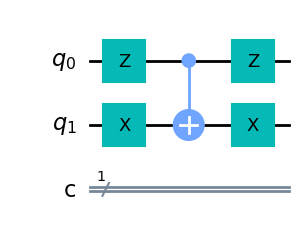

In [54]:
def commutative_commutation_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(QuantumRegister(2, "q"), ClassicalRegister(1, "c"))
    circuit.z(0)
    circuit.x(1)
    circuit.cx(0, 1)
    circuit.z(0)
    circuit.x(1)
    return circuit


circuit = commutative_commutation_circuit()

print("Before optimization:")
circuit.draw("mpl")

After optimization:


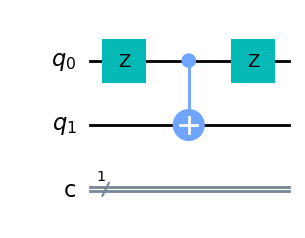

In [55]:
# 1q gate optimization
commutative_cancellation = PassManager([CommutativeCancellation(basis_gates=["cx", "u", "id"])])

# Get the result circuit
result = commutative_cancellation.run(circuit)

print("After optimization:")
result.draw("mpl")

We were able to successfully remove the two $X$ and $X$ gates by moving the gates and passing the

##### Optimize by comuting, unrolling and 1qgatedecomposition

By unrolling the circuit into a desired basis, we can have a circuit work on a
specific hardware. For our purposes, we are unrolling to the commonly used
universal gate set of rotation operators (
$R_x(\theta), R_y(\theta), R_z(\theta)$), and CNOT gate where the circuits will
be universal up to a global phase.

After unrolling the circuit, we can apply the `CommutativeCancellation` pass to
remove any gates that commute and are self inversing.


Before optimization:


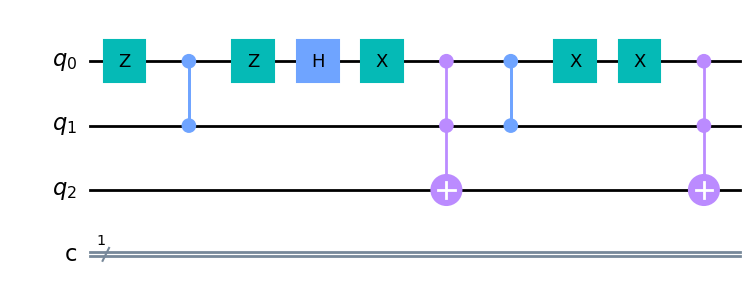

In [56]:
def unroll_circuit() -> QuantumCircuit:
    circuit = QuantumCircuit(QuantumRegister(3, "q"), ClassicalRegister(1, "c"))
    circuit.z(0)
    circuit.cz(1, 0)
    circuit.z(0)
    circuit.h(0)
    circuit.x(0)
    circuit.toffoli(0, 1, 2)
    circuit.cz(0, 1)
    circuit.x(0)
    circuit.x(0)
    circuit.ccx(0, 1, 2)
    return circuit


circuit = unroll_circuit()

print("Before optimization:")
circuit.draw("mpl")

Do you see any gates that commute? 

After optimization:


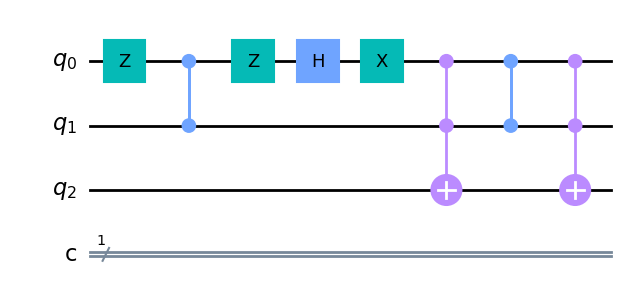

In [57]:
# Apply CommutativeCancellation
result = commutative_cancellation.run(circuit)
print("After optimization:")
result.draw("mpl")

In [58]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{result.depth()}")
print(f"New Gates:{sum(dict(result.count_ops()).values())}")

Original Depth:10
Original Gates:10
New Depth:8
New Gates:8


In [59]:
# unroll the circuit
from qiskit.transpiler.passes import Unroller

unroller = PassManager(
    [
        Unroller(
            basis=["p", "u", "cx", "id"],
        )
    ]
)

After optimization:


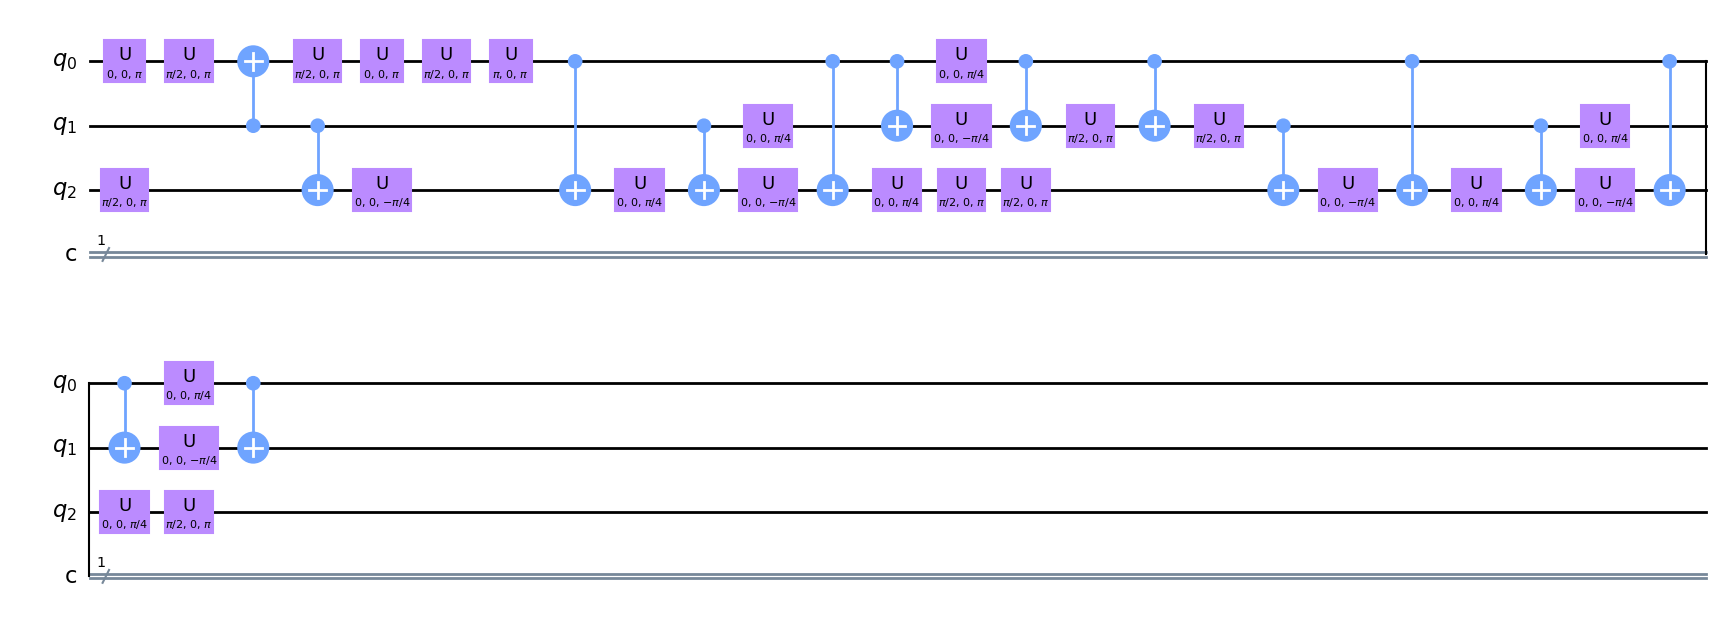

In [60]:
# Get the result circuit
result = unroller.run(result)

print("After optimization:")
result.draw("mpl")

In [61]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{result.depth()}")
print(f"New Gates:{sum(dict(result.count_ops()).values())}")

Original Depth:10
Original Gates:10
New Depth:28
New Gates:40


After optimization:


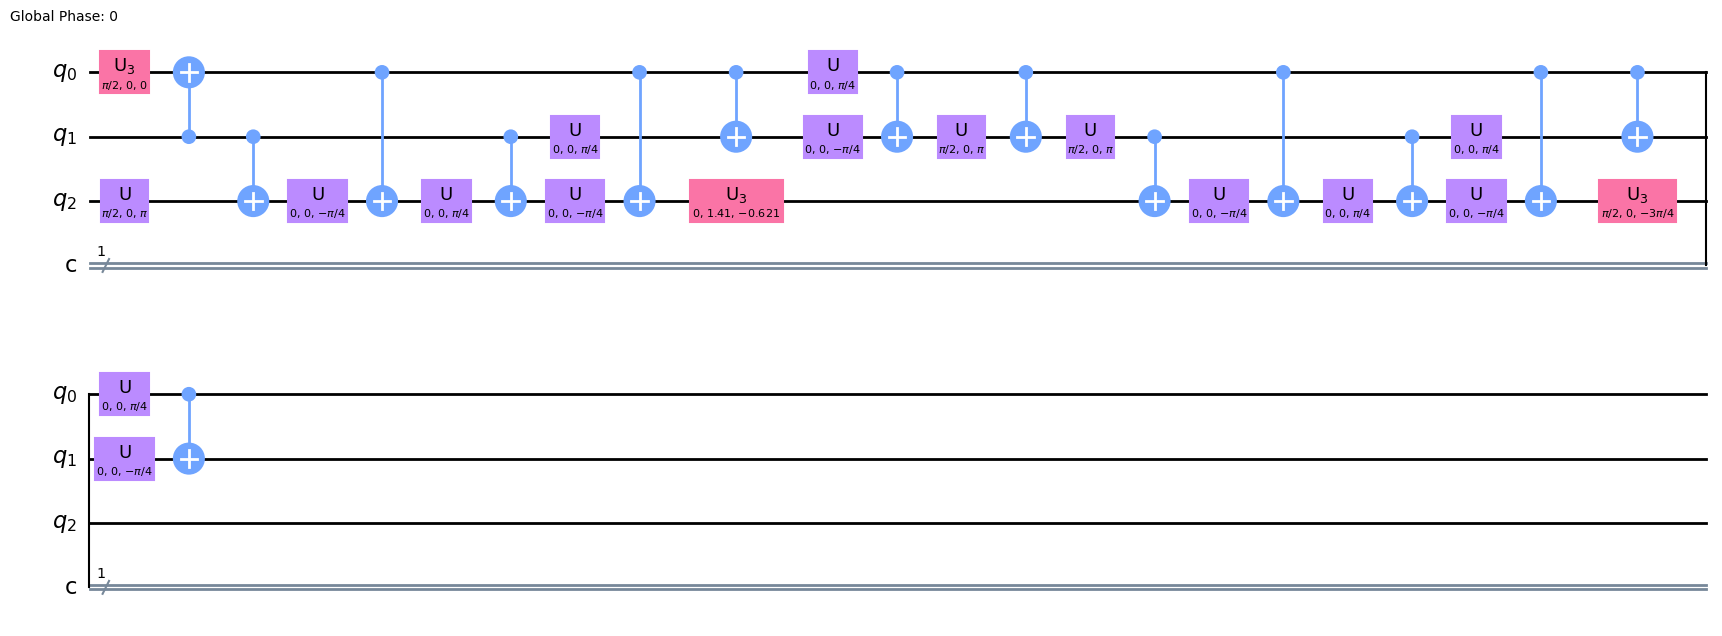

In [62]:
# Apply the 1 qubit gate decomposition
result = optimize_1q.run(result)
print("After optimization:")
result.draw("mpl")

In [63]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{result.depth()}")
print(f"New Gates:{sum(dict(result.count_ops()).values())}")

Original Depth:10
Original Gates:10
New Depth:25
New Gates:32


## [Reinforcement Learning](https://pytorch.org/rl/tutorials/coding_ppo.html)

A technique that can be applied to generate the optimal quantum circuit is to
use reinforcement learning.

<img src='./images/mario.png'>

### What is reinforcement learning?

Reinforcement learning is a machine learning technique that is used to train an
agent to perform a task. The agent is given a reward for performing an action in
an environment. The agent then learns to maximize the reward by performing the
optimal action in the environment.

We will now attempt to train an RL model to optimize a quantum circuit
referencing the following paper: https://arxiv.org/pdf/2103.07585.pdf


In this code, we define a quantum circuit using Qiskit and a reward function that
computes the fidelity between the output state of the circuit and a target
state. The QuantumEnvironment class represents the quantum environment in which
the agent interacts and is a custom environment made with Gymnasium by OpenAI. The Actor class represents the reinforcement learning
actor, which uses a neural network model built with Pytorch to approximate
the optimal action given a state. The training loop is where the agent interacts with the environment and updates its model based
on the observed rewards.


Please note that this is just a basic starter code, and you may need to modify
and extend it depending on your specific requirements and the complexity of the
quantum circuits you want to optimize. The code however is scalable and can accomodate arbitrary depth and number of qubits with the correct instantiation of the environment.


### Discrete Proximal Policy Optimization for Quantum Circuit Optimization
The following has been adapted from the pytorch reinforcement learning tutorial for using PPO in the famous cartpole problem:
https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html. We demonstrate how developing a custom environment and applying small tweaks to a PPO algorithm can be relatively simple to implement and can be used to optimize quantum circuits. The following code is adapted from the following paper: https://arxiv.org/pdf/2103.07585.pdf and is by no means a complete implementation of the paper. The following code is intended to be a starting point for you to explore the field and to try out your own ideas on how to optimize quantum circuits using reinforcement learning.


#### What is PPO?
Proximal Policy Optimization (PPO) is a policy gradient method that is used to train an agent to perform a task. The agent is given a reward for performing an action in an environment. The agent then learns to maximize the reward by performing the optimal action in the environment. PPO is an on-policy algorithm, meaning that it learns from the most recent experiences of the agent.

In [2]:
# Define the reinforcement learning agent
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

import gym_examples

### Our custom quantum environment

Our environment is a custom class that inherits from the OpenAI Gym environment class. 



#### State
The state of the environment is the quantum circuit that we want to optimize. The state is represented as a list of gates, where each gate is represented as a tuple of the gate name and the qubit indices that the gate acts on. We convert the circuit to a tensor with the shape of 

(num_qubits, available_gate_set, 5 )

where as a matrix the input tensor can be visually repsented as follows:

<img src="./images/input_tensor.png" width="350px">

In the original paper, the open source framework Cirq is used which includes the notion of moments. Although Qiskit has barriers, we do not include them in our input tensor. Instead we added the parameters of the gates ie the rotations that are applied by the gates for additional granularity.



#### Reward 
The reward is the fidelity between the output state of the circuit and a target state. The target state is the state that we want the circuit to output. As mentioned in [Fosel et al. (2021)]( https://arxiv.org/pdf/2103.07585.pdf), the target state can be the ground state of a Hamiltonian or a state that is generated by another quantum circuit. In this example, we use the ground state of a Hamiltonian as the target state. The reward is computed using the following equation:

$$r_t = -(q(s_{t+1})-q(s_t))$$

where $q(s)$ is the error probability for a circuit $s$ at some time $t$ between the output state of the circuit and the target state. [Fosel et al. (2021)]( https://arxiv.org/pdf/2103.07585.pdf) then defines the probability to successfully run a circuit as 

$$ P_{success} = \exp^{-m \Gamma T } \Pi^{n}_{k=1}u_k$$

where $m$ is the number of qubits, $\Gamma$ is the qubit loss of information during idle time and $u_k$ is the indicates how much thek-th gate underperforms compared to decay with rate $\Gamma$ during idle times.
The equiation may seem unintuitive, but setting a few constants and cleaning up the equation we get the following:

$$ q = - \ln P_{success} = m \Gamma T- \Sigma^{n}_{k=1}u_k$$

where $T$ is the total time of the circuit. The reward is then computed as the difference between the error probability of the circuit at time $t+1$ and the error probability of the circuit at time $t$.

Setting the constants $\alpha/m \Gamma$ and $u_k = \exp^{\beta}$ we get the following equation:

$$q(s) = \alpha d(s) + \beta n(s) $$


ah nice and clean, try to get the final equation yourself as an exercise. q(s) is just simply constnats $\alpha = 1$ and $\beta = 0.2$ according to the paper. d(s) is the depth of the circuit and n(s) is the number of gates in the circuit and our reward function comes out to:

```python
depth = optimized_circuit.depth()
gate_len = sum(dict(optimized_circuit.count_ops()).values())
score = self.alpha * depth + self.beta * gate_len
```

#### Action
The action is the transformation we want to apply to the circuit which the neural network should learn to pick as it receives feedback (reward) from the environment. For our use case we have the following actions:

```python
{
    0: Optimize1qGatesDecomposition(),
    1: CommutativeInverseCancellation(),
    2: CommutativeCancellation(basis_gates=basis),
    3: CXCancellation(),
    4: UnitarySynthesis(basis_gates=basis),
}
```

Note this isn't technically much differnt from applying a `transpile()` at optimization_level 2, 3 depending on the backend. However, we can train the neural network to learn the optimal sequence of transpilation passes to apply to the circuit and there's plenty more you can do! See future work.

Alright let's load the environment and check the specs

In [9]:
base_env = GymEnv("gym_examples/Quantum-v0")

In [10]:
env = TransformedEnv(
    base_env,
    # Compose(
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [11]:
env.transform[0].init_stats(num_iter=20, reduce_dim=0, cat_dim=0)

In [12]:
frame_skip = 1
frames_per_batch = 1 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 50_000 // frame_skip  # Set to 250 for the sake of time

In [13]:
sub_batch_size = (
    64  # cardinality of the sub-samples gathered from the current data in the inner loop
)
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = 0.2  # clip value for PPO loss: see the equation in the intro for more context.
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [14]:
rollout = env.rollout(11)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([11, 5]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([11, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([11, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([11, 12, 56, 5]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([11, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                step_count: Tensor(shape=torch.Size([11, 1]), device=cpu, dtype=torch.int64, is_shared=False)},
            batch_size=torch.Size([11]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([11, 12, 56, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([11, 1]),

In [15]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: BoundedTensorSpec(
        shape=torch.Size([12, 56, 5]),
        space=ContinuousBox(
            minimum=Tensor(shape=torch.Size([12, 56, 5]), device=cpu, dtype=torch.float32, contiguous=True), 
            maximum=Tensor(shape=torch.Size([12, 56, 5]), device=cpu, dtype=torch.float32, contiguous=True)),
        device=cpu,
        dtype=torch.float32,
        domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
        shape=torch.Size([1]),
        space=ContinuousBox(
            minimum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True), 
            maximum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
        device=cpu,
        dtype=torch.int64,
        domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
    shape=torch.Size([1]),
    space=ContinuousBox(
        minimum=Tensor(shape=torch.Size([]), device=cpu,

In [16]:
test_env = check_env_specs(env)

check_env_specs succeeded!


In [30]:
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.model = self.build_model()
        self.circuit_depth = 0
        self.writer = SummaryWriter()

    def build_model(self):
        # While the specifics of the architecture are not specified, it is mentioned they use a CNN
        model = nn.Sequential()
        model.append(nn.Conv2d(12, 16, kernel_size=2, stride=1, padding=1))
        model.append(nn.ReLU())
        model.append(nn.MaxPool2d(kernel_size=(2, 2), stride=1))
        model.append(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1))
        model.append(nn.ReLU())
        # model.append(nn.MaxPool2d(kernel_size=(2,2), stride=1))
        model.append(nn.Conv2d(32, 1, kernel_size=2, stride=1, padding=1))
        model.append(nn.ReLU())
        model.append(nn.Flatten())
        model.append(nn.LazyLinear(2 * env.action_spec.shape[-1]))

        model.append(NormalParamExtractor())
        return model

    def forward(self, x):
        return self.model(x)

    def update(self, states: QuantumCircuit, rewards, epoch):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters())
        # Convert the input state to a PyTorch tensor

        # Circuit Tensor
        tensor = create_tensor_from_circuit(states)

        rewards = torch.tensor(rewards, dtype=torch.float32)
        optimizer.zero_grad()
        predicted_rewards = self.forward(tensor)
        loss = criterion(predicted_rewards, rewards)
        self.writer.add_scalar("Loss/train", loss, epoch)
        loss.backward()
        optimizer.step()
        return loss.item()

In [31]:
agent = Actor()
model = agent.build_model()
summary(model, (12, 55, 5))

/Users/rickyyoung/opt/anaconda3/envs/rlco/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 5]                    --
├─Conv2d: 1-1                            [16, 56, 6]               784
├─ReLU: 1-2                              [16, 56, 6]               --
├─MaxPool2d: 1-3                         [16, 55, 5]               --
├─Conv2d: 1-4                            [32, 56, 6]               2,080
├─ReLU: 1-5                              [32, 56, 6]               --
├─Conv2d: 1-6                            [1, 57, 7]                129
├─ReLU: 1-7                              [1, 57, 7]                --
├─Flatten: 1-8                           [1, 399]                  --
├─Linear: 1-9                            [1, 10]                   4,000
├─NormalParamExtractor: 1-10             [1, 5]                    --
Total params: 6,993
Trainable params: 6,993
Non-trainable params: 0
Total mult-adds (M): 0.48
Input size (MB): 0.01
Forward/backward pass size (MB)

In [32]:
actor_net = agent.model
policy_module = TensorDictModule(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])
print(env.action_spec.shape[-1])

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": 0,
        "max": 4,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

5


In [33]:
device = "cpu"
value_net = nn.Sequential()
value_net.append(nn.Conv2d(12, 16, kernel_size=2, stride=1, padding=1))
value_net.append(nn.ReLU())
value_net.append(nn.MaxPool2d(kernel_size=(2, 2), stride=1))
value_net.append(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1))
value_net.append(nn.ReLU())
# value_net.append(nn.MaxPool2d(kernel_size=(2,2), stride=1))
value_net.append(nn.Conv2d(32, 1, kernel_size=2, stride=1, padding=1))
value_net.append(nn.ReLU())
value_net.append(nn.Flatten())
value_net.append(nn.LazyLinear(1))


value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [34]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([12, 56, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1, 5]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([12, 56, 5

In [35]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

In [36]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

In [37]:
advantage_module = GAE(gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True)
print(advantage_module.__dict__)
lr = 3e-4

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    # advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # # these keys match by default but we set this for completeness
    # value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)
# loss_module = loss_module.set_keys

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, total_frames // frames_per_batch, 0.0)

{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict([('gamma', tensor(0.9900)), ('lmbda', tensor(0.9500))]), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('value_network', ValueOperator(
    module=Sequential(
      (0): Conv2d(12, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(32, 1, kernel_siz

The model can take a while to train

In [ ]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""
num_epochs = 10
# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"] + loss_vals["loss_critic"] + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(eval_rollout["next", "reward"].sum().item())
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

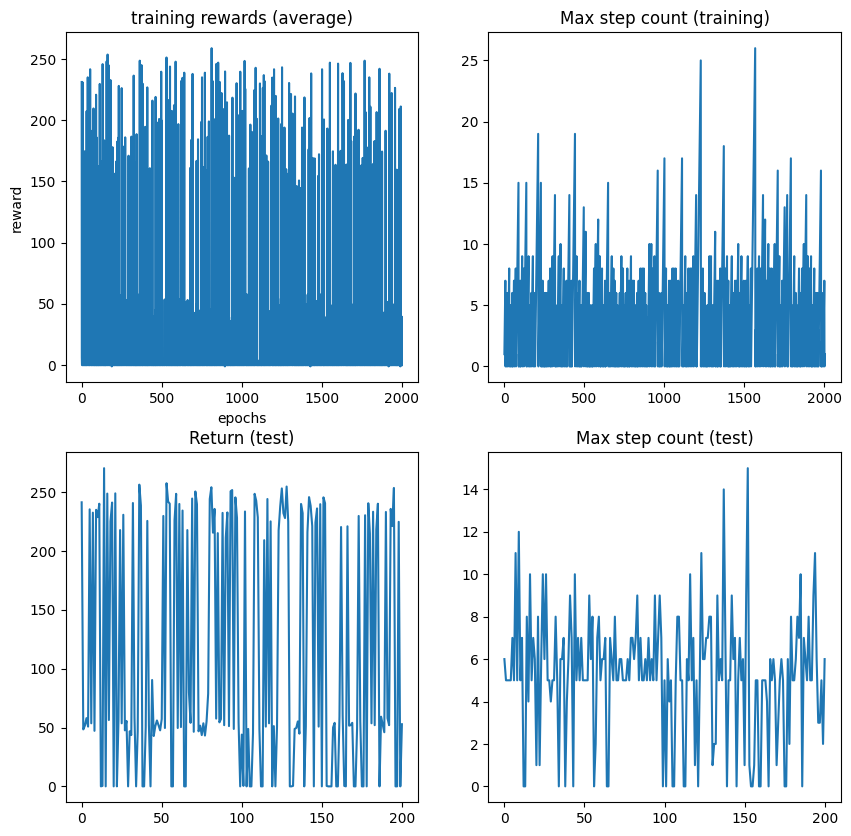

In [88]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.ylabel("reward")
plt.xlabel("epochs")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

In [92]:
torch.save(model.state_dict(), "ppo_model-version1.pt")

In [39]:
# Create a circuit that needs to be optimized


new_env = GymEnv("gym_examples/Quantum-v0")
model.load_state_dict(torch.load("ppo_model.pt"))
model.eval()

Sequential(
  (0): Conv2d(12, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=1, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(32, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=399, out_features=10, bias=True)
  (9): NormalParamExtractor()
)

In [40]:
new_env.reset()
circuit = new_env.circuit

In [41]:
print(circuit.depth())
print(new_env.state.shape)

1114
torch.Size([12, 57, 5])


In [ ]:
output = model(new_env.state)

In [202]:
prediction = output[1].detach().numpy()
print(prediction)

tensor(3)


In [218]:
# Get the action from the environment
qco_pass = new_env.actions[int(prediction)]
print(qco_pass)

### Now let's apply the the choice on the circuit and see if it optimizes the circuit

In [219]:
# Run the action on the circuit in the environment

rl_pass = PassManager([qco_pass])

new_circuit = rl_pass.run(circuit)

In [220]:
print(f"Original Depth:{circuit.depth()}")
print(f"Original Gates:{sum(dict(circuit.count_ops()).values())}")
print(f"New Depth:{new_circuit.depth()}")
print(f"New Gates:{sum(dict(new_circuit.count_ops()).values())}")

Original Depth:1051
Original Gates:7611
New Depth:1051
New Gates:6518


## Final Remarks

Can you say that this model is training after a few epochs? Most likely not, in fact running the full model would require quite a bit of time! However, this is a good starting point for you to explore the field and to try out your own ideas on how to optimize quantum circuits using reinforcement learning.


### Interested in running this on a GPU on qBraid? Fill out this form and we'll get back to you!
https://form.typeform.com/to/uRGyqJST

## Further Work

Convert circuits to tensor networks and optimize using tensor network
contractions

Account for gate positions in the circuit (moments)

Improve the reward function

Add custom passes to the optimization pipeline

Improve the step count

Tweak the convolutional neural network architecture

Use quantum circuits that are not random (ie QAOA, VQE, etc)


## References

Quantum circuit optimization with deep reinforcement learning: https://arxiv.org/pdf/2103.07585.pdf

Qiskit Transpiler: https://qiskit.org/documentation/apidoc/transpiler.html

PPO Tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html

Custom Environments: https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/